# Question 1: k-Nearest Neighbors Regression Model on the Automobile Dataset
## 1. Importing the necessary libraries

In [932]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Load the data

In [933]:
def load_data(data_path, file_name, column_names):
    return pd.read_csv(data_path+file_name, sep=",", names=column_names)


data_path = './dataset/'
file_name = 'imports-85.data'
column_names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
                'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
                'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders',
                'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower',
                'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

automobile = load_data(data_path, file_name, column_names)
automobile.head()
# automobile.info()
# automobile.describe()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## 3. Data Preprocessing

### (i) In the preprocessing stage we will first drop a few features. These features are:
   - symboling
   - normalized-losses
   - make
   - num-of-doors
   - drive-wheels
   - engine-location
   - engine-type
   - fuel system

In [934]:
# dropping a few categorical columns from the data
automobile = automobile.drop(['symboling', 'normalized-losses', 'make',
                              'num-of-doors', 'drive-wheels', 'engine-location',
                              'engine-type', 'fuel-system'], axis = 1)

### (ii) Data Inspection using info() method of Pandas

Based on inspection it is found that a few features like **bore**, **stroke**, **price** are of type object. These feature values need to be converted into float.

In [935]:
automobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel-type          205 non-null    object 
 1   aspiration         205 non-null    object 
 2   body-style         205 non-null    object 
 3   wheel-base         205 non-null    float64
 4   length             205 non-null    float64
 5   width              205 non-null    float64
 6   height             205 non-null    float64
 7   curb-weight        205 non-null    int64  
 8   num-of-cylinders   205 non-null    object 
 9   engine-size        205 non-null    int64  
 10  bore               205 non-null    object 
 11  stroke             205 non-null    object 
 12  compression-ratio  205 non-null    float64
 13  horsepower         205 non-null    object 
 14  peak-rpm           205 non-null    object 
 15  city-mpg           205 non-null    int64  
 16  highway-mpg        205 non

In [936]:
# converting the features of type object to float
object_type_features = ['bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
for feature in object_type_features:        
    automobile[feature] = pd.to_numeric(automobile[feature], errors='coerce')

There are a few datapoints for which the **price** (target feature) value is missing, these rows will be dropped from the dataframe.


In [937]:
# keep the rows where price (our target feature) is NOT-NULL
automobile = automobile[automobile['price'].notna()]

### (iii) OneHotEncoding of Important Categorical Features

We will use one-hot-encoding to encode the remaining categorical features. These features are:
  - fuel-type
  - aspiration
  - body-style
  - num-of-cylinders

In [938]:
def one_hot_encoding(dataframe, features_to_encode):
    
    for feature in features_to_encode:
        dummies = pd.get_dummies(dataframe[feature])  # get the dummies for the feature
        dataframe = pd.concat([dataframe, dummies], axis=1)  # concatenate the dummies in the dataframe
        dataframe = dataframe.drop(feature, axis=1)  # drop the original feature column
    
    return dataframe

# using one-hot-encoding for rest of the categorical columns
features_to_encode = ['fuel-type', 'aspiration', 'body-style', 'num-of-cylinders']
automobile = one_hot_encoding(automobile, features_to_encode)

### (iv) Handle Missing Values

Some of the features have missing values which will be imputed with the mean value of the column

In [939]:
features_with_missing_values = ['bore', 'stroke', 'horsepower', 'peak-rpm']

for feature in features_with_missing_values:
    automobile[feature].fillna(automobile[feature].mean(), inplace = True)

### (v) Feature Scaling

For our problem we will use min-max feature scaling. Also, before scaling we will extract the target column aside as we don't want to scale the target column. 
Later, we will merge the price column back to the dataframe.

In [940]:
# split automobile dataframe into data and target columns
data = automobile.drop('price', axis=1)
target = automobile['price'].copy()
    
# do min-max normalization of all the features in the dataframe data
data = (data - data.min()) / (data.max() - data.min())

# concatenate the price column to the features
automobile = pd.concat([data, target], axis=1)

Our data looks like this after preprocessing

In [941]:
data.head()

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,...,hatchback,sedan,wagon,eight,five,four,six,three,twelve,two
0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 4. Checking Correlations

For this we will use the corr() method from the **pandas** library

In [942]:
# calculate the correlation of all the features with the 'price' (target feature) feature
correlation = automobile.corr()['price'].sort_values().to_frame()
print(' The correlation values in increasing order are \n', correlation)

 The correlation values in increasing order are 
                       price
highway-mpg       -0.704692
four              -0.691968
city-mpg          -0.686571
hatchback         -0.293121
std               -0.179578
gas               -0.110326
peak-rpm          -0.101542
three             -0.071860
wagon             -0.039707
two               -0.003364
compression-ratio  0.071107
stroke             0.082267
diesel             0.110326
height             0.135486
sedan              0.148105
turbo              0.179578
convertible        0.192142
twelve             0.203311
hardtop            0.231180
five               0.254019
eight              0.461834
six                0.486096
bore               0.543154
wheel-base         0.584642
length             0.690628
width              0.751265
horsepower         0.809681
curb-weight        0.834415
engine-size        0.872335
price              1.000000


#### It seems that the top 5 feautures with highest correlation with price feature are following -
 - length            --> 0.690628
 - width             --> 0.751265
 - horsepower        --> 0.809681
 - curb-weight       --> 0.834415
 - engine-size       --> 0.872335
 
 
 We will construct scatter plots for these for simple visualization

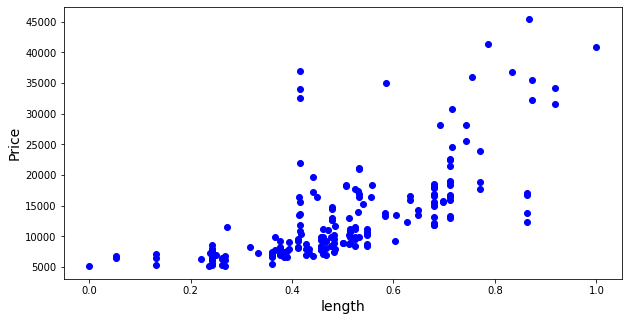

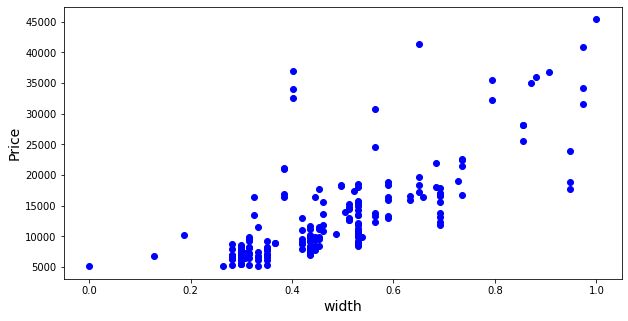

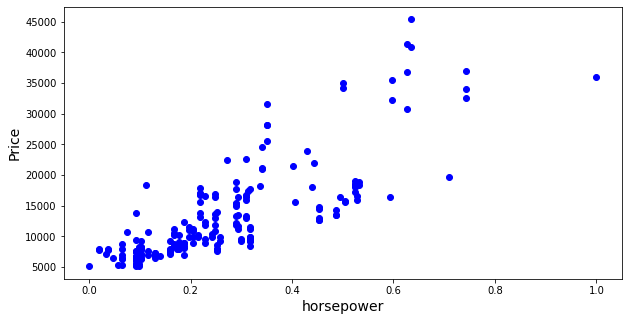

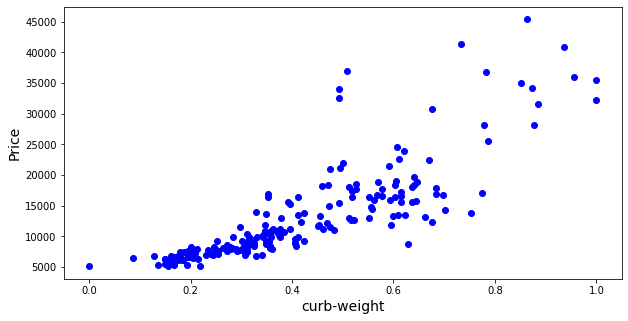

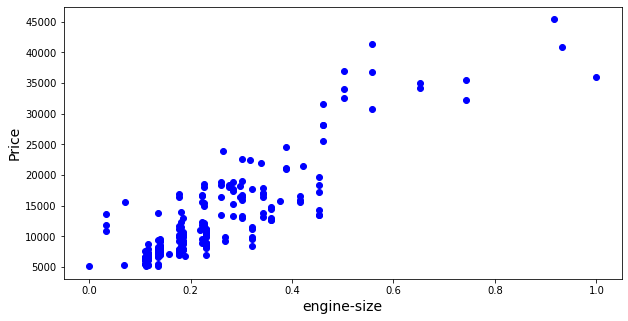

In [944]:
features_to_plot = ['length', 'width', 'horsepower', 'curb-weight', 'engine-size']

for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(automobile[feature], automobile['price'], color='b')
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Price', fontsize=14)

plt.show()

## 4. Split the Data into Train and Test Set

Now, we will split the data into training and test set. We will us random shuffling with the *random_state=42*.

In [945]:
# split the data such that training samples contain 80% of the total data and testing samples contain rest 20%
train_data = automobile.sample(frac=0.8, random_state=42)
test_data = automobile.drop(train_data.index) # drop the train data from dataframe to extract the test data

# split the target column from the training data
train_target = train_data['price'].copy()
train_data = train_data.drop('price', axis=1)

# split the target column from the testing data
test_target = test_data['price'].copy()
test_data = test_data.drop('price', axis=1)

# convert all dataframes to numpy arrays, it will be easier to work with numpy arrays
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_target = train_target.to_numpy()
test_target = test_target.to_numpy()

print(train_data.shape, test_data.shape)
# train_data.info()
# test_data.info()

(161, 29) (40, 29)


## 5. K-Nearest Neighbor Regression

### (i) Define kNNRegressor function

In [946]:
def kNNRegressor(train_data, train_target, x, k):
    '''
    This function take the training data and the test data point as input
    and predicts the label for the test datapoint
    '''
    
    # calculate the difference vector by subtracting the test data from training data
    difference_vectors = train_data - x
    
    # calculate the l2 norm of each vector
    distance_matrix = np.linalg.norm(difference_vectors, axis=1)
    
    # sort the distance matrix
    idx = np.argsort(distance_matrix)
    pred = 0
    
    # iterate over k nearest neighbors and return average label value 
    for i in range(k):
        pred += train_target[idx[i]]

    return pred/k

### (ii) Define a function for calculating Root-Mean-Squared-Errors for the Test Data

In [947]:
def RMSE_for_kNNRegressor(train_data, train_target, test_data, test_target, k=2):
    '''
    This function uses the kNNRegressor function defined earlier and
    calculates RMSE for each test data point in the testing dataset
    '''
    
    # create empty vector to store the predicted labels
    target_vector = np.array([])
    
    # iterate over each test data point
    for x in test_data:
        target = kNNRegressor(train_data, train_target, x, k)
        target_vector = np.append(target_vector, target)
    
    # calculate RMSE by using the target vector predicted by our algorithm and the actual values of target column
    rmse = np.sqrt(np.sum(np.square(target_vector - test_target)) / test_data.shape[0])
    return rmse

### (iii) Run the algorithm on the test data set

We will now run our kNN-Regression algorithm on the test data set and report the root-mean-squared-error

RMSE for k = 1 is 2825.7491573032453
RMSE for k = 2 is 3067.3210288051037
RMSE for k = 3 is 3291.910784618697
RMSE for k = 4 is 4103.8780076364965
RMSE for k = 5 is 4527.3458191306745
RMSE for k = 6 is 4866.621522764363
RMSE for k = 7 is 4598.087198743071
RMSE for k = 8 is 4520.968683793745
RMSE for k = 9 is 4403.867463364053
RMSE for k = 10 is 4315.337907626702


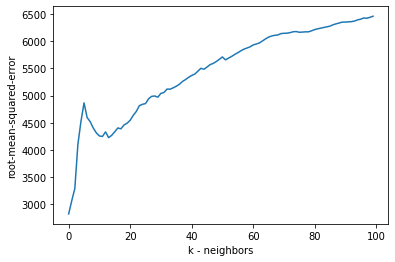

In [948]:
# create an empty array to store the RMSE for various values of k
rmse_for_varying_k = np.array([])
# we will calculate rmse for k between 1 to 100
for k in range(1, 100+1):
    error = RMSE_for_kNNRegressor(train_data, train_target, test_data, test_target, k)
    rmse_for_varying_k = np.append(rmse_for_varying_k, error)

    # Print values for k = 1 to k = 10
    if k <= 10: print('RMSE for k = '+str(k)+' is', error)

# plot the root-mean-squared-error for k= 1 to 100
plt.plot(rmse_for_varying_k)
plt.xlabel('k - neighbors')
plt.ylabel('root-mean-squared-error')
plt.show()

By observing the trend of error for different values of k, the curve seems to form an elbow-shaped pattern.
With increasing value of k, you take more and more neighbors into the picture and the variance of the model decreases. This causes higher error.

## 6. Hyper-parameter Tuning using 4-Fold Cross Validation

### (i) Define the KFoldCrossValidation Function

This function will calculate the average RMSE (root-mean-squared-error) of all the validation set resulting from 4-Fold CV

In [949]:
def KFoldCrossValidation(data, k=2, n_folds=4):
    '''
    This functions take the training data as input along with 'k' and number of folds to be
    used for the kFoldCrossValidation. It returns the average error on validation set
    '''
    
    # size of single data split for the given number of folds
    piece_size = int(data.shape[0] / n_folds)
    
    # copy the data into a seperate variable
    data_copy = np.copy(data)
    
    # shuffle the rows in the data
    np.random.shuffle(data_copy)  # shuffle happens inplace
    
    error = 0
    
    # iterate over each piece of data and calculate average RMSE over the validation set
    for i in range(0, n_folds):
        
        # create an array of indexes for validation data
        # for ex: when i=0 the indexes for validation set would be [0...39]
        # when i=1 the indexes for validation set would be [40...79] and so on.
        val_data_indexes = np.arange(i*piece_size, (i+1)*piece_size)
        
        # extract the validation data based on the above indexes
        val_data = data_copy[val_data_indexes]
        
        # extract the training data by removing the rows belonging to the indexes of validation data
        train_data = np.delete(data_copy, val_data_indexes, axis=0)
        
        # split train data and the target column (last column)
        train_target = train_data[:, -1]
        train_data = train_data[:, :-1]
        
        # split validation data and the target column (last column)
        val_target = val_data[:, -1]
        val_data = val_data[:, :-1]

        # sum all the values of errors on each validation set formed in the splits
        error += RMSE_for_kNNRegressor(train_data, train_target, val_data, val_target, k)
        
    # return the average error on validation set
    return error/n_folds

### (ii) Define the hyperparameterTuningWithKFoldCV function

This function will calculate the best value of k parameter (k in the k-NN-Regression algorithm) based on kFoldCV

In [950]:
def hyperparameterTuningWithKFoldCV(data, lower_k=1, higher_k=50, n_folds=4):
    '''
    This function will take the data as input along with
    lower and upper bound of the hyperparameter value,
    and the number of folds in KFoldCrossValidation.
    It returns the minimum error reported and the value of
    parameter 'k' for which the minimum error is reported
    '''
    
    # initialize minimum rmse variable with infinity
    min_rmse = float('inf')
    
    # iterate over the parameter k in the given range
    for k in range(lower_k, higher_k+1):
        # calculate rmse
        rmse = KFoldCrossValidation(data, k, n_folds=4)
        # update rmse if it is less than the current min_rmse and also update best value of parameter k
        if rmse < min_rmse:
            min_rmse = rmse
            best_k = k
    
    # return the min root-mean-squared-error and also the corresponding best value of parameter k
    # reported in the KFoldCrossValidation
    return (min_rmse, best_k)

### (iii) Calculate Minimum Error and the Best Value of k based on 4-FoldCV

This function will calculate the best value of k parameter (k in the k-NN-Regression algorithm) based on kFoldCV

In [952]:
train = np.c_[train_data, train_target]  # we will merge the target column of training data with all the features

min_r, best_k = hyperparameterTuningWithKFoldCV(train, lower_k=1, higher_k=50, n_folds=4)    
print('The minimum root-mean-squared-error is', min_r, 'at k =', best_k)

The minimum root-mean-squared-error is 3522.4999441933555 at k = 2


-------------------------------------------------------------------------------------- End of Question 1 (a) and (b) -------------------------------------------------------------------------------

# Question 2: Decision Tree Classification Model on the Census Income Data
## 1. Load Data

**Note** - The target feature 'income' has values '>50K' and '<=50K'. We will replace these values by 1 and 0 to make things simpler. 

In [953]:
data_path = './dataset/'
file_name = 'adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

income_data = load_data(data_path, file_name, column_names)
income_data.head()


# replace values in target column ('income') with '<=50k' as 0 and '>50k' as 1
income_data['income'].replace('<=50K', 0, inplace=True)
income_data['income'].replace('>50K',1, inplace=True)

# income_data.info()
# income.describe()
# income_data['native-country'].value_counts()

## 2. Data Preprocessing

### (i) Drop the irrelevant features
            
In the first step of preprocessing we will drop a few irrelevant features from the dataframe. These features are:
- fnlwgt
- marital-status
- race
- sex

In [954]:
# drop a few categorical features
income_data = income_data.drop(['fnlwgt', 'marital-status', 'race', 'sex'], axis=1)

### (ii) Handle missing data
For simplicity we will drop the rows containing missing data in any column

In [955]:
# delete the rows where data is missing
for feature in income_data:
    # keep only those rows where value is not null
    income_data = income_data[income_data[feature].notna()]
    
# Replace missing values in work-class with 'Private' which is the mode (most occuring category) of that column
income_data['workclass'].replace('?', 'Private', inplace=True)
income_data['workclass'].value_counts()

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

### (ii) One-Hot-Encoding and Label Encoding of Important Categorical Features

The important categorical features will be encoded using the one-hot-encoding function defined earlier. The following features will be encoded:
- workclass
- education
- relationship

The features **occupation** and **native-country** will be encoded using label encoding as it has a lot of unique values

In [956]:
# using one-hot-encode function defined earlier
features_to_encode = ['workclass', 'education', 'relationship']
income_data = one_hot_encoding(income_data, features_to_encode)
income_data.head()


# defining label-encoder
def label_encode(dataframe, features_to_label_encode):
    
    for feature in features_to_label_encode:
        # convert feature into category type
        dataframe[feature] = dataframe[feature].astype('category')
        # assing labels based on category and add column into the dataframe
        dataframe[feature+'-label'] = dataframe[feature].cat.codes
        # drop the original feature column
        dataframe = dataframe.drop(feature, axis=1)
    
    return dataframe

# label encode the features
features_to_label_encode = ['occupation', 'native-country']
income_data = label_encode(income_data, features_to_label_encode)

In [957]:
income_data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,Federal-gov,Local-gov,Never-worked,Private,...,Prof-school,Some-college,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,occupation-label,native-country-label
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,39
1,50,13,0,0,13,0,0,0,0,0,...,0,0,1,0,0,0,0,0,4,39
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,39
3,53,7,0,0,40,0,0,0,0,1,...,0,0,1,0,0,0,0,0,6,39
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,10,5


## 3. Split the Data into Train and Test Set

Now, we will split the data into training and test set. We will us random shuffling with the *random_state=42*.

In [958]:
# split the data such that training samples contain 80% of the total data and testing samples contain rest 20%
train_data = income_data.sample(frac=0.8, random_state=42)
test_data = income_data.drop(train_data.index) # drop the train data from dataframe to extract the test data

# split the target column from the training data
train_target = train_data['income'].copy()
train_data = train_data.drop('income', axis=1)

# split the target column from the testing data
test_target = test_data['income'].copy()
test_data = test_data.drop('income', axis=1)

# convert all dataframes to numpy arrays, it will be easier to work with numpy arrays
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_target = train_target.to_numpy()
test_target = test_target.to_numpy()

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)
# train_data.info()
# test_data.info()

(26049, 37) (26049,) (6512, 37) (6512,)


## 4. Building Class and Functions for Decision Tree Classifier

### (i) Define the Node Class

The node class represents the node object in the decision tree


**NOTE**: A lot of help is taken from the demo code shared by **Prof. Nisheeth Srivastava**. I have tried to write my own logic wherever possible although there would be a lot of similarity in the code skeleton with demo notebook.

In [959]:
class Node():
    '''
    Node class for creating nodes in decision tree
    '''
    def __init__(self, depth=0, stump=(0, 0), parent=None):
        '''
        The constructor does useful initializations for the newly created node.
        Left and right child are initialized to None and label is initialized to dummy value -1
        '''
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.leaf = True  # all nodes are initialized as leaf
        self.label = -1
        
    def entropy(self, target_column):
        '''
        This functions calculates the entropy of the current node
        '''
        H = 0
        unique_labels = np.unique(target_column)
        for label in unique_labels:
            p = len(target_column[target_column == label]) / target_column.shape[0]
            H = H + (-p * np.log2(p))
        return H
    
    def information_gain(self, current_data_target, left_split_target, right_split_target):
        '''
        Calculate the information gain by using the labels of data available in the current node
        and the labels of data split towards left and right nodes
        '''
        left_factor = len(left_split_target)/len(current_data_target)
        right_factor = len(right_split_target)/len(current_data_target)
        ig = self.entropy(current_data_target) - \
                    left_factor*self.entropy(left_split_target) - right_factor*self.entropy(right_split_target)

        return ig
    
    def predict(self, data_point):
        '''
        Function to predict the label of given datapoint
        If the current node is leaf node return its label, else recursively call for left or right subtree
        '''
        if self.leaf:
            return self.label
        else:
            if data_point[self.stump[0]] > self.stump[1]:
                return self.right.predict(data_point)
            else:
                return self.left.predict(data_point)
            
    def get_stump(self, train_data, train_target):
        '''
        The getStump function takes the data and target column as input and returns the feature
        along with a threshold value. The split over this threshold value over the calculated 
        feature gives the highest information gain 
        '''
        # initialize max_information_gain variable with -infinity, it will
        # be used to find the feature and corresponding threshold with highest information_gain
        max_information_gain = float('-inf')
        
        # merging the target column in the data
        # this will make it easier to split the data later in this function
        dataset = np.c_[train_data, train_target]  

        # For each of the features in the data
        for i in range(train_data.shape[1]):
            
            # if the node is root then continue to next iteration of the loop and
            # do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            
            # find out all the possible thresholds for the feature
            threshold_list = np.sort( train_data[:, i] )
            
            # Since the values might be repeated, we keep only unique threshold values
            threshold_list = np.unique(threshold_list)
            
            for j in range(1, threshold_list.size-1):
                
                # find the data for left tree and right tree and find the infromation gain of the current node
                left_data = dataset[dataset[:, i] <= threshold_list[j], :]  # indexing the data points for left split
                right_data = dataset[dataset[:, i] > threshold_list[j], :]  # indexing the data points for right split
                
                # split the target column from the datasets
                left_split_target = left_data[:, -1]
                right_split_target = right_data[:, -1]
                
                # calculate the information gain at the current node with the current threshold value and feature
                curr_information_gain = self.information_gain(train_target, left_split_target, right_split_target)
        
                if curr_information_gain > max_information_gain:
                    max_information_gain = curr_information_gain
                    best_feature = i
                    best_threshold = threshold_list[j]
        
        return (best_feature, best_threshold)

    
    def train(self, train_data, train_target, max_depth, max_leafsize):
        '''
        The train function takes training data and labels along with tree parameters depth and leafsize
        It recursively constructs the tree by calculating stump and forwarding the split data into left and 
        right subtrees
        '''
        # if the datapoints at the current node exceed the allowed leaf size, or
        # the if the depth of the current node exceeds the allowed max_depth
        # then make the current node as leaf node and assign it the majority label
        if train_target.size < max_leafsize or self.depth >= max_depth:
            self.leaf = True
            self.label = np.bincount(train_target).argmax()  # assign the majority label to this node (now leaf)
        
        else:
            # split the current node and find the best decision stump
            self.leaf = False # since the node is split, its not a leaf anymore
            
            # Get the best possible decision stump
            self.stump = self.get_stump(train_data, train_target)
            
            # recursively construct left and right child
            self.left = Node(depth=self.depth+1, parent=self)
            self.right = Node(depth=self.depth+1, parent=self)
            
            # Now we have to find the datapoints to give to the respective left and right child
            # to do this we will create a mask
            # the rows where the mask is true will be assigned to left tree
            # and the points where the mask is false ill be assigned to the right tree
            
            # we will first merge the target column to the data
            dataset = np.c_[train_data, train_target]
            
            # now we will create a mask that is true wherever stump condition is satisfied
            mask = dataset[:, self.stump[0]] <= self.stump[1]
            
            # the left node training data can be extracted using the mask
            left_train_data = dataset[mask, :]
            
            # the right node training data can be extracted using the not(mask)            
            right_train_data = dataset[~mask, :]
            
            # extract the target column for the left and right side data using the similar technique as above
            left_train_target = dataset[mask, -1]
            right_train_target = dataset[~mask, -1]
            
            # recursively call train on left and right child
            self.left.train(left_train_data, left_train_target, max_depth, max_leafsize)
            self.right.train(right_train_data, right_train_target, max_depth, max_leafsize)

### (ii) Define the 'DecisionTreeClassifier' Class

We will use this class to initialize DecisionTreeClassfier object to train the model and predict

In [960]:
class DecisionTreeClassifier():
    '''
    Class for our Decision Tree Classifier
    It initialized root node and can be used train and construct the decision tree
    '''
    def __init__(self, max_depth=8, max_leafsize=10):
        self.root = Node()
        self.max_depth = max_depth
        self.max_leafsize = max_leafsize
    
    def train(self, train_data, train_target):
        self.root.train(train_data, train_target, self.max_depth, self.max_leafsize)
    
    def predict(self, x):
        return self.root.predict(x)

###  (iii) Train the Decision Tree Classifier Model on the Dataset

For this we will create a simple function that uses above defined DecisionTreeClassifier class and takes various inputs like training data, training target labels, test data, test target labels, max depth of the tree, and max leafsize. This function will give the accuracy of our model as output.

In [961]:
def DTClassifier(train_data, train_target, test_data, test_target, max_depth=5, max_leafsize=10):

    # create DecisionTreeClassifier object and train with the training data
    dt_classifier = DecisionTreeClassifier(max_depth, max_leafsize)
    dt_classifier.train(train_data, train_target)
    
    # calculate the predictions for the test data
    test_pred = np.array([])  # emtpy numpy array to store the prediction values for each data point
    for x in test_data:
        pred = dt_classifier.predict(x)
        test_pred = np.append(test_pred, pred)

    # to calculate the acccuracy, we find the mean of number of matches between the elements of the two vectors
    accuracy_score = np.mean(test_target == test_pred)
    
    return accuracy_score

In [962]:
accuracy = DTClassifier(train_data, train_target, test_data, test_target, max_depth=5, max_leafsize=10)
print('The accuracy of our Decision Tree Classifier is ', accuracy)

The accuracy of our Decision Tree Classifier is  0.831541769041769


## 4. Hyper-parameter Tuning using 4-Fold Cross Validation

### (i) Define the KFoldCrossValidation Function

This function will calculate the average accuracy of all the validation set resulting from 4-Fold CV

In [963]:
def KFoldCrossValidation(data, max_leafsize=10, max_depth=5, n_folds=4):
    '''
    This functions take the training data as input along with hyperparameters to tune and number of folds to be
    used for the kFoldCrossValidation. It returns the average accuracy on validation set.
    '''
    
    # size of single data split for the given number of folds
    piece_size = int(data.shape[0] / n_folds)
    
    # copy the data into a seperate variable
    data_copy = np.copy(data)
    
    # shuffle the rows in the data
    np.random.shuffle(data_copy)  # shuffle happens inplace
    
    accuracy = 0
    
    # iterate over each piece of data and calculate average RMSE over the validation set
    for i in range(0, n_folds):
        
        # create an array of indexes for validation data
        # for ex: when i=0 the indexes for validation set would be [0...39]
        # when i=1 the indexes for validation set would be [40...79] and so on.
        val_data_indexes = np.arange(i*piece_size, (i+1)*piece_size)
        
        # extract the validation data based on the above indexes
        val_data = data_copy[val_data_indexes]
        
        # extract the training data by removing the rows belonging to the indexes of validation data
        train_data = np.delete(data_copy, val_data_indexes, axis=0)
        
        # split train data and the target column (last column)
        train_target = train_data[:, -1]
        train_data = train_data[:, :-1]
        
        # split validation data and the target column (last column)
        val_target = val_data[:, -1]
        val_data = val_data[:, :-1]

        # sum all the values of accuracy on each validation set formed in the splits
        accuracy += DTClassifier(train_data, train_target, val_data, val_target, max_depth, max_leafsize)
        
    # return the average accuracy on validation set
    return accuracy/n_folds

### (ii) Define the hyperparameterTuningWithKFoldCV function

This function will calculate the best value of max_depth and max_leafsize parameters for the decision tree model based on kFoldCV

In [966]:
def hyperparameterTuningWithKFoldCV(data, lower_depth=2, higher_depth=20, lower_leafsize=2,
                                    higher_leafsize=20, n_folds=4):
    '''
    This function will take the data as input along with
    lower and upper bound of the hyperparameter value,
    and the number of folds in KFoldCrossValidation.
    It returns the maximum accuracy reported and the value of
    parameters for which the maximum accuracy is reported.
    '''
    
    
    print('KFoldCrossValidation for the various values of leafsize and depth: ')
    
    # initialize maximum accruacy variable with -infinity
    max_accuracy = float('-inf')
    
    # iterate over the parameter depth in the given range
    for depth in range(lower_depth, higher_depth+1):
        
        # iterate over the parameter leaf_size in the given range
        for leafsize in range(lower_leafsize, higher_leafsize+1):
            
            # calculate average validation set accuracy
            accuracy = KFoldCrossValidation(data, leafsize, depth, n_folds)

            print('The accuracy is', accuracy, ' at depth =', depth, ' and leafsize =', leafsize)
            
            # update accuracy if it is more than the current max_accuracy and also update best value
            # of parameter max_depth and max_leafsize
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_max_depth = depth
                best_max_leafsize = leafsize
    
    # return the max accuracy and also the corresponding best value of parameters
    # for the decision tree reported in the KFoldCrossValidation
    return (max_accuracy, best_max_depth, best_max_leafsize)

### (iii) Calculate Minimum Error and the Best Value of k based on 4-FoldCV

This function will calculate the best value of depth and leafsize parameter based on kFoldCV

In [969]:
train = np.c_[train_data, train_target]  # we will merge the target column of training data with all the features

max_accuracy, best_max_depth, best_max_leafsize = hyperparameterTuningWithKFoldCV(train, lower_depth=5, higher_depth=8,
                                                                                  lower_leafsize=8, higher_leafsize=10,
                                                                                  n_folds=4)    

print('The maximum accuracy is', max_accuracy, 'at depth =', best_max_depth, 'and leafsize =', best_max_leafsize)

KFoldCrossValidation for the various values of leafsize and depth: 
The accuracy is 0.8239404176904177  at depth = 5  and leafsize = 8
The accuracy is 0.8230574324324323  at depth = 5  and leafsize = 9
The accuracy is 0.8223280098280098  at depth = 5  and leafsize = 10
The accuracy is 0.824477886977887  at depth = 6  and leafsize = 8
The accuracy is 0.8266277641277642  at depth = 6  and leafsize = 9
The accuracy is 0.8261670761670761  at depth = 6  and leafsize = 10
The accuracy is 0.8251305282555282  at depth = 7  and leafsize = 8
The accuracy is 0.8271652334152334  at depth = 7  and leafsize = 9
The accuracy is 0.8273955773955775  at depth = 7  and leafsize = 10
The accuracy is 0.8260135135135136  at depth = 8  and leafsize = 8
The accuracy is 0.8263590294840295  at depth = 8  and leafsize = 9
The accuracy is 0.8269732800982801  at depth = 8  and leafsize = 10
The maximum accuracy is 0.8273955773955775 at depth = 7 and leafsize = 10


-------------------------------------------------------------------------------------- End of Question 2 (a) and (b) -------------------------------------------------------------------------------